In [ ]:
!pip install category_encoders
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/weatherAUS.csv", sep=',')

In [ ]:
df_2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AirQualityUCI.csv", sep=';')

## preprocessing

In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,145460,3436,2013-11-12,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,145460,49,Canberra,3436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinTemp,143975.0,NaN,NaN,NaN,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,NaN,NaN,NaN,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,NaN,NaN,NaN,2.360918,8.47806,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,NaN,NaN,NaN,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,NaN,NaN,NaN,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustDir,135134,16,W,9915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpeed,135197.0,NaN,NaN,NaN,40.03523,13.607062,6.0,31.0,39.0,48.0,135.0
WindDir9am,134894,16,N,11758,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Extracting Weekday and Month into separate columns
df['Weekday'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [ ]:
df_clean = df.dropna(subset=["Rainfall", "RainToday", "RainTomorrow"])

For variables with low missing data (around 3% of the dataset), I plan to delete rows with any missing values in crucial columns such as Rainfall, RainToday, and RainTomorrow, given the dataset's considerable size.

In [ ]:
# Define a condition for rows based on Rainfall and RainToday columns
condition = ((df_clean['Rainfall'] >= 1) & (df_clean['RainToday'] == 'Yes')) | ((df_clean['Rainfall'] < 1) & (df_clean['RainToday'] == 'No'))

# Update the 'RainToday' column for rows that do not satisfy the condition, setting their 'RainToday' value to 'Yes'
df_clean.loc[~condition, 'RainToday'] = 'Yes'

assigned the variable Rainfall correctly

In [ ]:
# Retrieve Numeric and Categorical Columns
numeric_columns_list = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns_list = df_clean.select_dtypes(include=['object']).columns.tolist()

# Group by Month and Region, then calculate the median for each numeric column
monthly_region_median = df_clean.groupby(['Month', 'Location'])[numeric_columns_list].median()

# Group by Month and Region, then calculate the mode for each categorical column
# For empty modes, use None; otherwise, use the mode value
monthly_region_mode = df_clean.groupby(['Month', 'Location'])[categorical_columns_list].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Some regions may have no values for a given month. In such cases, fill missing values with overall median/mode
monthly_region_median.fillna(monthly_region_median.mean(), inplace=True)
monthly_region_mode.fillna(monthly_region_mode.mode().iloc[0], inplace=True)

I use the median, not the mean, to address outliers in certain variables. The chosen missing data imputation method is effective for my goal, considering analysis needs. While more complex approaches exist, I opt for simplicity. Monthly imputation adequately captures seasonal trends. For month/region combinations with exclusively missing data, using data from a single or similar regions is an option.

In [ ]:
def fillna_udf(row: pd.Series, dataframe_for_fill: pd.DataFrame, columns: list) -> pd.Series:

    location = row['Location']  # Get the value from the 'region' column of the row
    month = row['Month']    # Get the value from the 'month' column of the row

    # Get the corresponding row in the DataFrame containing replacement mode/median
    impute_row = dataframe_for_fill.loc[(month, location)]

    # Replace missing values with medians/modes
    for col in columns:
        if pd.isna(row[col]):
            row[col] = impute_row[col]
    return row

# Apply the fillna_udf function to each row of df_clean for numeric columns
df_clean = df_clean.apply(lambda row: fillna_udf(row, monthly_region_median, numeric_columns_list), axis=1)
print("ok1")
# Apply the fillna_udf function to each row of df_clean for categorical columns
df_clean = df_clean.apply(lambda row: fillna_udf(row, monthly_region_mode, categorical_columns_list), axis=1)
print("ok2")

ok1
ok2


In [ ]:
def cap_outliers_interquartile_range(data_frame, columns_to_cap):
    """
    Caps outliers in specified columns using the Interquartile Range (IQR) method.

    :param data_frame: The DataFrame containing the data.
    :param columns_to_cap: List of columns to cap outliers.
    :return: The updated DataFrame with capped outliers.
    """
    for column in columns_to_cap:
        lower_bound = data_frame[column].quantile(0.25) - 1.5 * (data_frame[column].quantile(0.75) - data_frame[column].quantile(0.25))
        upper_bound = data_frame[column].quantile(0.75) + 1.5 * (data_frame[column].quantile(0.75) - data_frame[column].quantile(0.25))
        data_frame[column] = np.where(data_frame[column] < lower_bound, lower_bound, data_frame[column])
        data_frame[column] = np.where(data_frame[column] > upper_bound, upper_bound, data_frame[column])
    return data_frame

columns_to_capitalize = ['Evaporation', 'WindSpeed9am']

# Apply Interquartile Range (IQR) capping to outliers
cap_outliers_interquartile_range(df_clean, columns_to_capitalize).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Weekday,Month,Year
0,2008-12-01,Albury,13.4,22.9,0.6,5.116752,8.5775,W,44.0,W,...,1007.1,8.0,5.0,16.9,21.8,No,No,0,12,2008
1,2008-12-02,Albury,7.4,25.1,0.0,5.116752,8.5775,WNW,44.0,NNW,...,1007.8,7.0,5.0,17.2,24.3,No,No,1,12,2008
2,2008-12-03,Albury,12.9,25.7,0.0,5.116752,8.5775,WSW,46.0,W,...,1008.7,7.0,2.0,21.0,23.2,No,No,2,12,2008
3,2008-12-04,Albury,9.2,28.0,0.0,5.116752,8.5775,NE,24.0,SE,...,1012.8,7.0,5.0,18.1,26.5,No,No,3,12,2008
4,2008-12-05,Albury,17.5,32.3,1.0,5.116752,8.5775,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,Yes,No,4,12,2008


I choose to cap, not remove, outliers to retain records of extreme data while mitigating their impact on analyses. While not explicitly aiming to detect natural disasters, these outliers may hold crucial information about exceptional events. Retaining them with a threshold value ensures analysis robustness without significant result distortion.

In [ ]:
df_clean=df_clean.drop(['Date'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder



df_clean['RainTomorrow'] = df_clean['RainTomorrow'].map({'No': 0, 'Yes': 1})
df_clean['RainToday'] = df_clean['RainToday'].map({'No': 0, 'Yes': 1})

encoder = TargetEncoder()
label_encoder = LabelEncoder()

for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df_clean[col] = label_encoder.fit_transform(df_clean[col])


# Specify the column you want to encode ('Location' in this case)
col = 'Location'
df_clean[col] = encoder.fit_transform(df_clean[col], df_clean['RainTomorrow'])



X = df_clean.drop(columns=['RainTomorrow'])  # Features
y = df_clean['RainTomorrow']  # Target variable


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train)

In [ ]:
df_clean.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Location,140787.0,0.221618,0.066076,0.066354,0.185149,0.225096,0.266917,0.366957
MinTemp,140787.0,12.188119,6.400488,-8.500000,7.600000,12.000000,16.800000,33.900000
MaxTemp,140787.0,23.235811,7.112066,-4.800000,17.900000,22.600000,28.200000,48.100000
Rainfall,140787.0,2.349974,8.465173,0.000000,0.000000,0.000000,0.800000,371.000000
Evaporation,140787.0,4.948942,2.210017,0.300000,3.600000,5.116752,5.800000,9.100000
Sunshine,140787.0,8.094868,2.868427,0.000000,7.500000,8.577500,9.500000,14.500000
WindGustDir,140787.0,7.387159,4.828483,0.000000,3.000000,8.000000,12.000000,15.000000
WindGustSpeed,140787.0,39.880922,13.154116,6.000000,31.000000,38.192376,46.000000,135.000000
WindDir9am,140787.0,7.275721,4.500273,0.000000,3.000000,7.000000,11.000000,15.000000
WindDir3pm,140787.0,7.757790,4.586801,0.000000,4.000000,8.000000,12.000000,15.000000


## preprocessing

In [ ]:
df_2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,9357,391,21/09/2004,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,9357,24,18.00.00,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO(GT),9357,104,-200,1592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PT08.S1(CO),9357.0,NaN,NaN,NaN,1048.990061,329.83271,-200.0,921.0,1053.0,1221.0,2040.0
NMHC(GT),9357.0,NaN,NaN,NaN,-159.090093,139.789093,-200.0,-200.0,-200.0,-200.0,1189.0
C6H6(GT),9357,408,"-200,0",366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PT08.S2(NMHC),9357.0,NaN,NaN,NaN,894.595276,342.333252,-200.0,711.0,895.0,1105.0,2214.0
NOx(GT),9357.0,NaN,NaN,NaN,168.616971,257.433866,-200.0,50.0,141.0,284.0,1479.0
PT08.S3(NOx),9357.0,NaN,NaN,NaN,794.990168,321.993552,-200.0,637.0,794.0,960.0,2683.0
NO2(GT),9357.0,NaN,NaN,NaN,58.148873,126.940455,-200.0,53.0,96.0,133.0,340.0


In [ ]:
df_2=df_2.drop(['Unnamed: 15'], axis=1)
df_2=df_2.drop(['Unnamed: 16'], axis=1)

As we can see, some columns are not seen as numbers. So we'll fix that

In [ ]:
numeric_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
                   'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
                   'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
#Making data numeric
df_2[numeric_columns] = df_2[numeric_columns].replace(',', '.', regex=True).astype(float)
df_2.replace(-200, np.nan, inplace=True)
#dropping rows where C6H6(GT)=np.nan
df_2 = df_2[df_2['C6H6(GT)'].notna()]

further we replace all values -200 by np.nan and remove the rows in the table where the value C6H6(GT)=np.nan, because it makes no sense to fill in the target value.

In [ ]:
df_2['Date'] = pd.to_datetime(df_2['Date'], format='%d/%m/%Y')

# Extracting Weekday and Month into separate columns
df_2['Weekday'] = df_2['Date'].dt.dayofweek  # Monday=0, Sunday=6
df_2['Month'] = df_2['Date'].dt.month


df_2['Time'] = pd.to_datetime(df_2['Time'], format='%H.%M.%S', errors='coerce')

# Extracting hours, minutes, and seconds
df_2['hour'] = df_2['Time'].dt.hour
df_2['minute'] = df_2['Time'].dt.minute
df_2['second'] = df_2['Time'].dt.second

# Combining hours, minutes, and seconds into a decimal representation
df_2['Time_numeric'] = df_2['hour'] + df_2['minute'] / 60 + df_2['second'] / 3600

<ipython-input-19-a17eb28bdd45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Date'] = pd.to_datetime(df_2['Date'], format='%d/%m/%Y')
<ipython-input-19-a17eb28bdd45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Weekday'] = df_2['Date'].dt.dayofweek  # Monday=0, Sunday=6
<ipython-input-19-a17eb28bdd45>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
df_2.describe(include="all").T

<ipython-input-20-d3cabe9d72b4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_2.describe(include="all").T
<ipython-input-20-d3cabe9d72b4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_2.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Date,8991,383,2004-09-19 00:00:00,24,2004-03-10,2005-04-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,8991,24,1900-01-01 09:00:00,378,1900-01-01,1900-01-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO(GT),7344.0,NaN,NaT,NaN,NaT,NaT,2.129711,1.436472,0.1,1.1,1.8,2.8,11.9
PT08.S1(CO),8991.0,NaN,NaT,NaN,NaT,NaT,1099.833166,217.080037,647.0,937.0,1063.0,1231.0,2040.0
NMHC(GT),887.0,NaN,NaT,NaN,NaT,NaT,218.607666,206.61513,7.0,66.0,145.0,297.0,1189.0
C6H6(GT),8991.0,NaN,NaT,NaN,NaT,NaT,10.083105,7.44982,0.1,4.4,8.2,14.0,63.7
PT08.S2(NMHC),8991.0,NaN,NaT,NaN,NaT,NaT,939.153376,266.831429,383.0,734.5,909.0,1116.0,2214.0
NOx(GT),7396.0,NaN,NaT,NaN,NaT,NaT,242.189292,206.312007,2.0,97.0,178.0,321.0,1479.0
PT08.S3(NOx),8991.0,NaN,NaT,NaN,NaT,NaT,835.493605,256.81732,322.0,658.0,806.0,969.5,2683.0
NO2(GT),7393.0,NaN,NaT,NaN,NaT,NaT,112.145137,47.629141,2.0,77.0,109.0,140.0,333.0


In [ ]:
df_2=df_2.drop(['Date'], axis=1)
df_2=df_2.drop(['Time'], axis=1)
df_2=df_2.drop(['hour'], axis=1)
df_2=df_2.drop(['minute'], axis=1)
df_2=df_2.drop(['second'], axis=1)

In [ ]:
columns_to_impute = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
                      'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
                      'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Weekday', 'Month', 'Time_numeric']

'''numeric_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
                   'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
                   'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']'''

#df[numeric_columns] = df[numeric_columns].replace(',', '.', regex=True).astype(float)


# Imputer strategies
strategies = {'CO(GT)': 'mean',
              'PT08.S1(CO)': 'median',
              'NMHC(GT)': 'median',
              'C6H6(GT)': 'most_frequent',
              'PT08.S2(NMHC)': 'median',
              'NOx(GT)': 'median',
              'PT08.S3(NOx)': 'median',
              'NO2(GT)': 'mean',
              'PT08.S4(NO2)': 'mean',
              'PT08.S5(O3)': 'mean',
              'T': 'mean',
              'RH': 'mean',
              'AH': 'mean',
              'Weekday':'most_frequent',
              'Month':'most_frequent',
              'Time_numeric':'mean' }

# Impute missing values
for column in columns_to_impute:
    imputer = SimpleImputer(strategy=strategies[column])
    df_2[column] = imputer.fit_transform(df_2[[column]]).ravel()

# Check if missing values are imputed
print(df.isnull().sum())

unknown_counts = df_2.apply(lambda x: x.value_counts().get(np.nan, 0))

# Print the counts of 'unknown' before replacement
print("Counts of 'unknown' before replacement:")
print(unknown_counts)

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
Weekday              0
Month                0
Year                 0
dtype: int64
Counts of 'unknown' before replacement:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Weekday          0
Month            0
Time_numeric     0
dtype: int64


I filled messing values using this ideas

Mean Imputation:
Suitable for numerical data with a normal distribution and when missing values are random.

Median Imputation:
Robust to outliers, suitable for non-normally distributed numerical data or ordinal data.

Most Frequent Imputation:
Appropriate for categorical or discrete data when missing values are random.

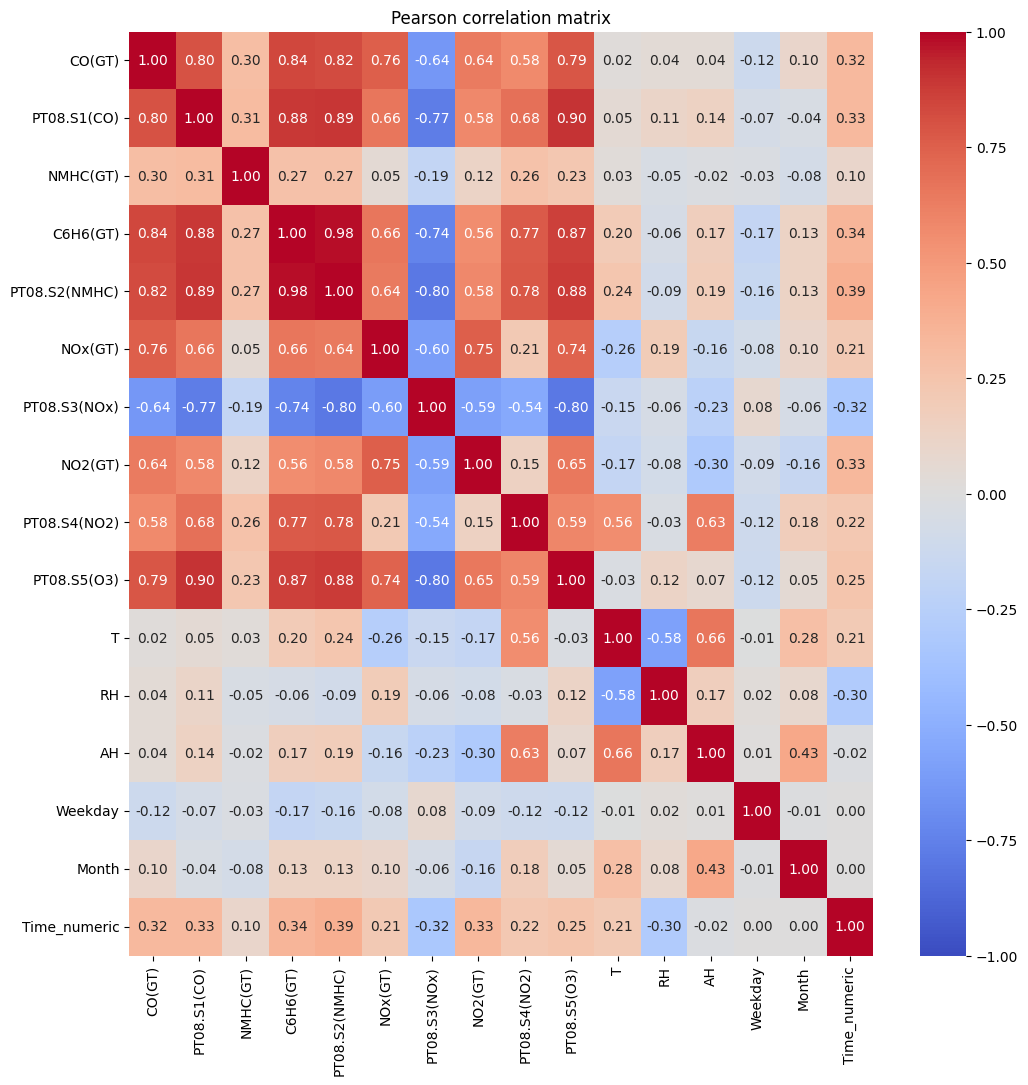

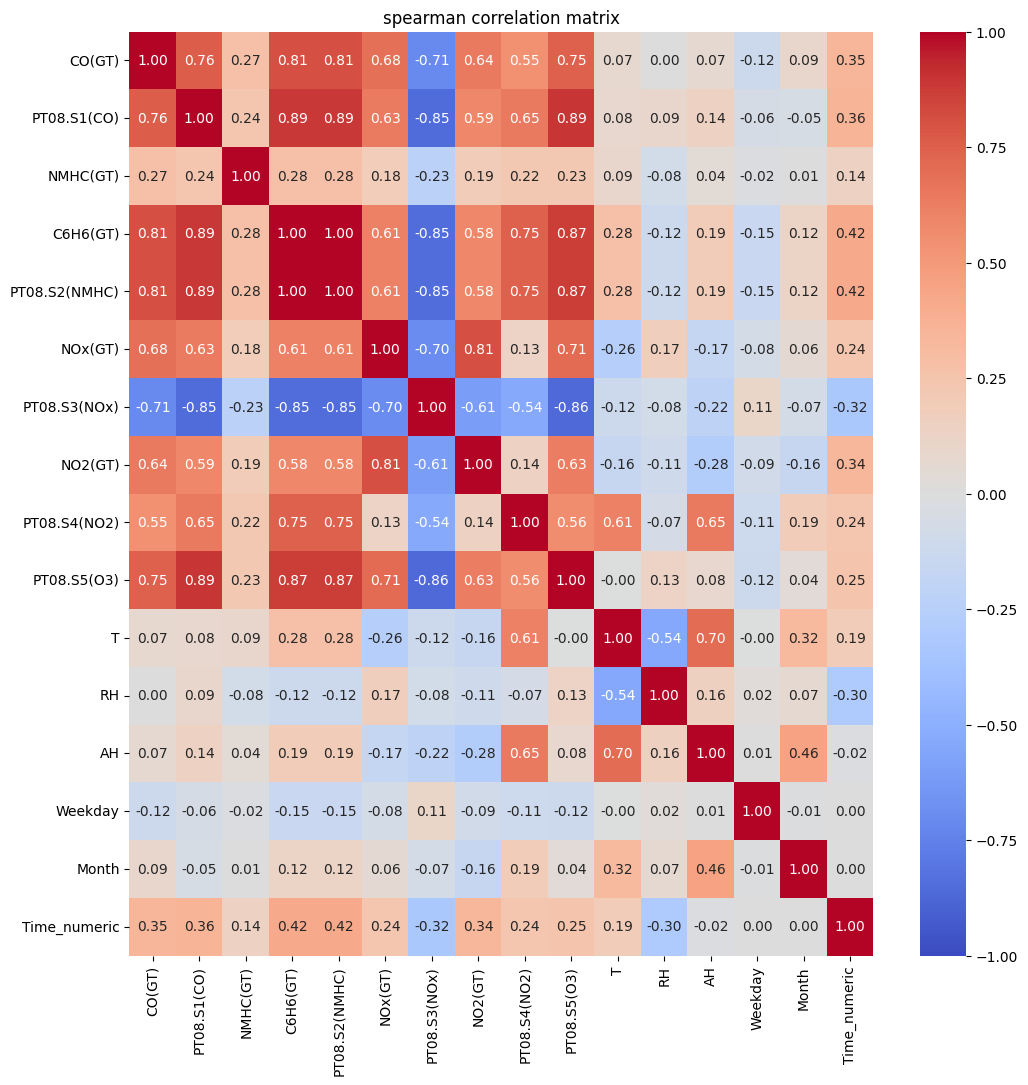

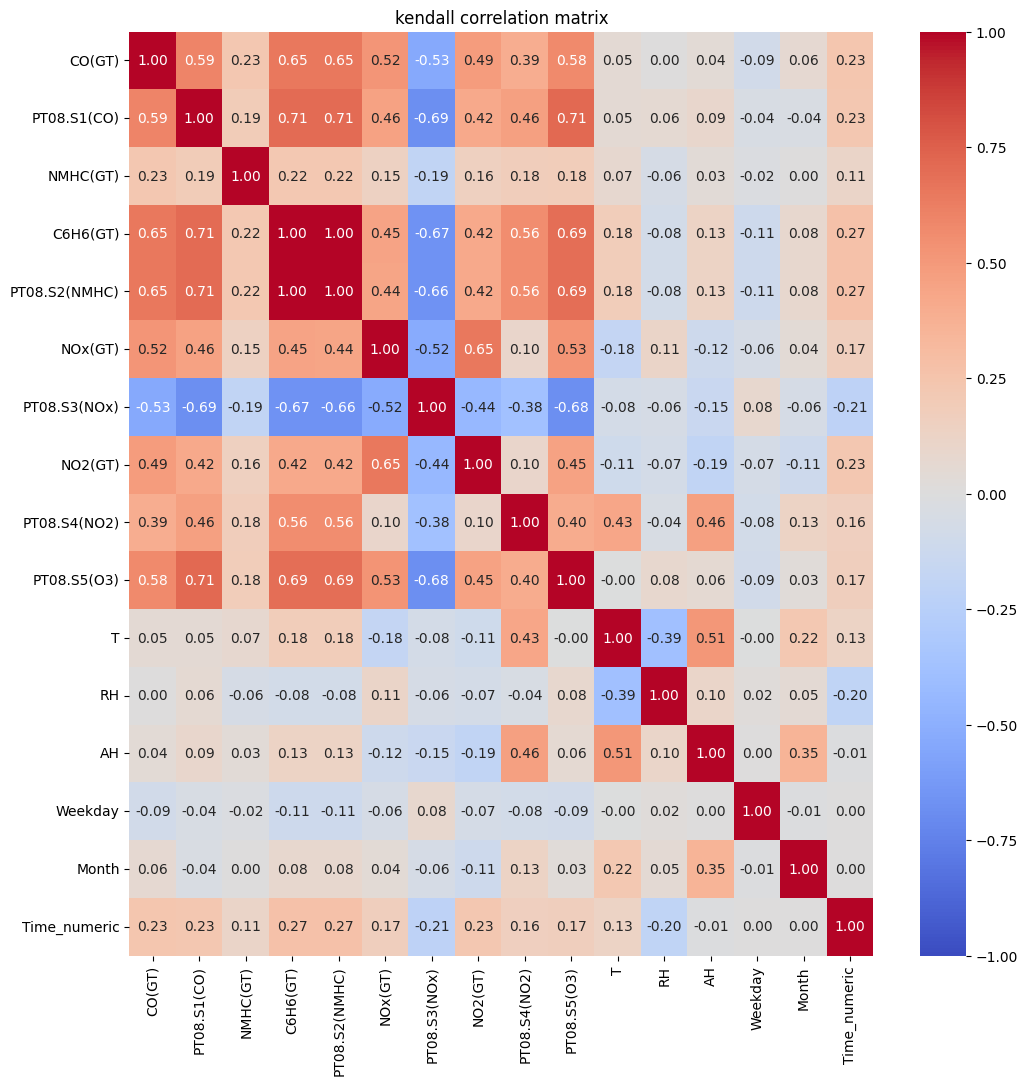

In [ ]:
subset=df_2.copy()
spearman_corr = subset.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(spearman_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Pearson correlation matrix")
plt.show()

spearman_corr = subset.corr(method='spearman')
plt.figure(figsize=(12, 12))
sns.heatmap(spearman_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("spearman correlation matrix")
plt.show()

spearman_corr = subset.corr(method='kendall')
plt.figure(figsize=(12, 12))
sns.heatmap(spearman_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("kendall correlation matrix")
plt.show()

As we can see, columns like T,RH,AH, weekday, month, NMHC(GT) and Time have low correlation with our target value, so we can remove these columns from the table

In [ ]:
df_2=df_2.drop(['T'], axis=1)
df_2=df_2.drop(['RH'], axis=1)
df_2=df_2.drop(['AH'], axis=1)
df_2=df_2.drop(['NMHC(GT)'], axis=1)
df_2=df_2.drop(['Weekday'], axis=1)
df_2=df_2.drop(['Month'], axis=1)
df_2=df_2.drop(['Time_numeric'], axis=1)

In [ ]:
def normalize_column(df_2):
    # Use RobustScaler to normalize the data
    scaler = RobustScaler()
    df_2 = scaler.fit_transform(df_2)
    return df_2

In [ ]:
normalize_column(df_2)

array([[ 0.33592048,  1.01020408,  0.38541667, ...,  0.01818857,
         0.51230425,  0.56273063],
       [-0.09265095,  0.77891156,  0.125     , ..., -0.42861994,
         0.2147651 ,  0.01660517],
       [ 0.05020619,  1.15306122,  0.08333333, ...,  0.03946516,
         0.20581655,  0.20479705],
       ...,
       [ 0.19306334,  0.26870748,  0.4375    , ...,  1.3373375 ,
        -0.4966443 ,  0.23800738],
       [-0.02122238, -0.20408163,  0.13541667, ...,  0.93308219,
        -0.94407159, -0.35608856],
       [ 0.05020619,  0.02721088,  0.38541667, ...,  1.18840133,
        -0.74720358, -0.27121771]])

In [ ]:
df_2.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
CO(GT),8991.0,2.129711,1.298237,0.1,1.2,2.129711,2.6,11.9
PT08.S1(CO),8991.0,1099.833166,217.080037,647.0,937.0,1063.000000,1231.0,2040.0
C6H6(GT),8991.0,10.083105,7.449820,0.1,4.4,8.200000,14.0,63.7
PT08.S2(NMHC),8991.0,939.153376,266.831429,383.0,734.5,909.000000,1116.0,2214.0
NOx(GT),8991.0,230.802135,188.717210,2.0,112.0,178.000000,280.0,1479.0
PT08.S3(NOx),8991.0,835.493605,256.817320,322.0,658.0,806.000000,969.5,2683.0
NO2(GT),8991.0,112.145137,43.189073,2.0,85.0,112.145137,132.0,333.0
PT08.S4(NO2),8991.0,1456.264598,346.206794,551.0,1227.0,1463.000000,1674.0,2775.0
PT08.S5(O3),8991.0,1022.906128,398.484288,221.0,731.5,963.000000,1273.5,2523.0


# Decision Tree Regressor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names=None):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Regression Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Feature Importance (if applicable)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        feature_importance = model.feature_importances_
        indices = np.argsort(feature_importance)

        plt.barh(range(len(indices)), feature_importance[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'{type(model).__name__} - Feature Importance')
        plt.show()

    # Display evaluation metrics
    print("\n===== Model Evaluation =====")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Explained Variance: {explained_variance:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    # Return evaluation metrics
    evaluation_metrics = {
        'Mean Squared Error': mse,
        'R-squared': r2,
        'Mean Absolute Error': mae,
        'Explained Variance': explained_variance,
        'Root Mean Squared Error': rmse,
    }

    return evaluation_metrics



Mean Squared Error: 0.013818788215675367


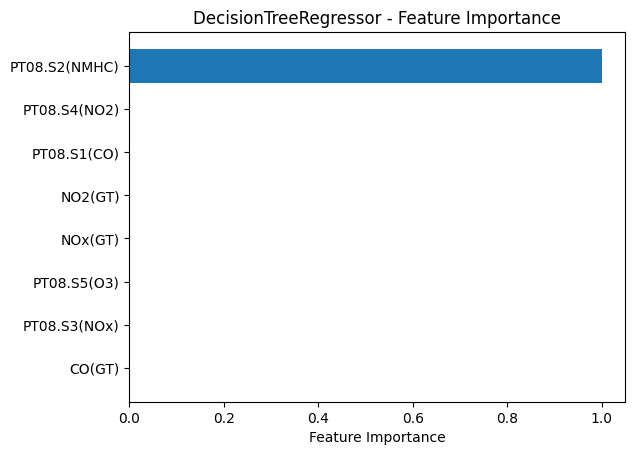


===== Model Evaluation =====
Mean Squared Error: 0.0138
R-squared: 0.9998
Mean Absolute Error: 0.0166
Explained Variance: 0.9998
Root Mean Squared Error: 0.1176
{'Mean Squared Error': 0.013818788215675367, 'R-squared': 0.9997595150358755, 'Mean Absolute Error': 0.01656475819900095, 'Explained Variance': 0.9997596010709666, 'Root Mean Squared Error': 0.11755334200130325}


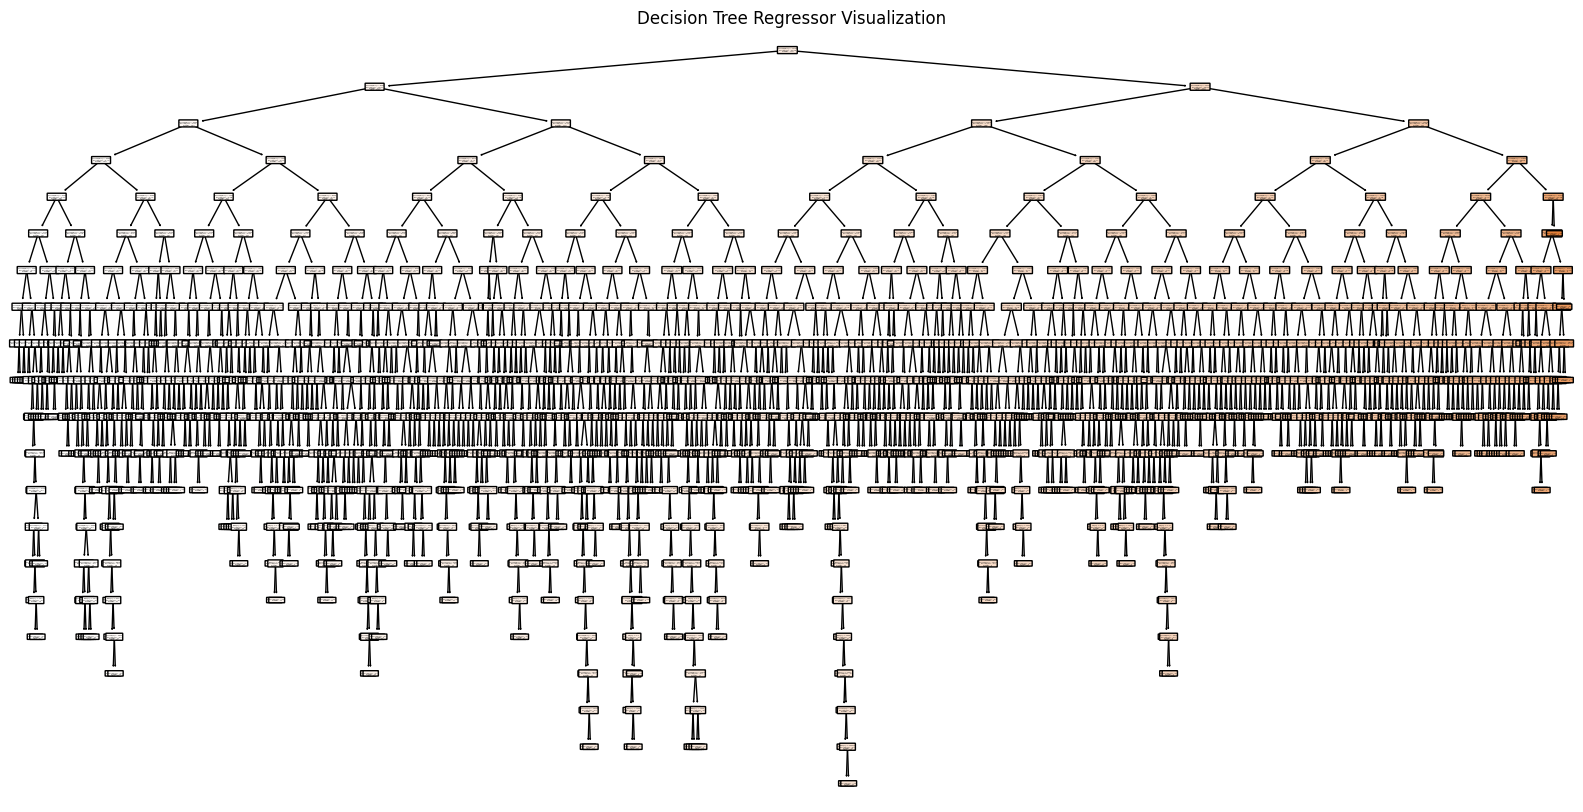

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


X = df_2.drop('C6H6(GT)', axis=1)
y = df_2['C6H6(GT)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_regressor.fit(X_train, y_train)

# Make predictions
y_pred = dt_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

evaluation_results = evaluate_model(dt_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, filled=True, feature_names=X.columns, class_names=['No Rain', 'Rain'], rounded=True)
plt.title('Decision Tree Regressor Visualization')
plt.show()




A low MSE (0.0138 in this case) suggests that the model's predictions are close to the actual values on average.

A high R² value (0.9998 in this case, very close to 1) indicates that the model explains a very high percentage of the variance in the response variable.

A low MAE (0.0166 in this case) implies that, on average, the model's predictions are very close to the actual values.
s.
A high Explained Variance (0.9998 in this case) suggests that the model captures almost all the variability in the data.

A low RMSE (0.1176 in this case) indicates that, on average, the model's predictions are close to the actual values.

The results suggest that the Decision Tree Regressor model performs exceptionally well on the given dataset. The model's predictions are very close to the actual values, and it explains a high percentage of the variance in the target variable.

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


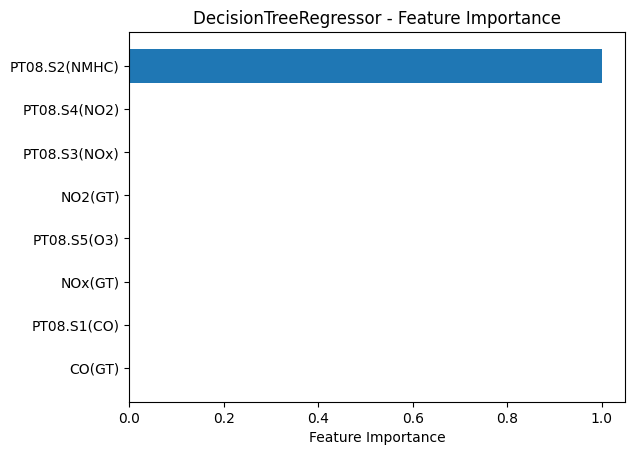


===== Model Evaluation =====
Mean Squared Error: 0.0070
R-squared: 0.9999
Mean Absolute Error: 0.0161
Explained Variance: 0.9999
Root Mean Squared Error: 0.0834
{'Mean Squared Error': 0.0069528498049333766, 'R-squared': 0.9998790012691557, 'Mean Absolute Error': 0.016071244256444715, 'Explained Variance': 0.9998790024579151, 'Root Mean Squared Error': 0.08338375024507699}


In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'max_depth': [5, 10, 15,20],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 4,6]
}

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best model
best_dt_regressor = grid_search.best_estimator_

# Make predictions
y_pred_tuned = best_dt_regressor.predict(X_test)


evaluation_results = evaluate_model(best_dt_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)



A lower MSE (0.0070 in this case) compared to the previous results (0.0138) suggests an improvement in the model's ability to make more accurate predictions with reduced error.

An exceptionally high R² value of 0.9999 indicates that the tuned Decision Tree Regressor explains nearly all the variability in the target variable.

A low MAE (0.0161 in this case) implies that, on average, the model's predictions are very close to the actual values.

A high Explained Variance (0.9999 in this case) suggests that the tuned model captures almost all the variability in the data.

A low RMSE (0.0834 in this case) indicates that, on average, the model's predictions are very close to the actual values.

In summary, the tuned Decision Tree Regressor has further improved its performance compared to the untuned version. The model now exhibits an extremely high level of accuracy, explaining nearly all the variability in the target variable while keeping the errors low.

Most Influential Features:
PT08.S2(NMHC): 0.9999602319527794
PT08.S4(NO2): 2.9209452779933607e-05
PT08.S3(NOx): 4.160912364489687e-06
NO2(GT): 1.7275240577713242e-06
PT08.S5(O3): 1.5375043919227584e-06


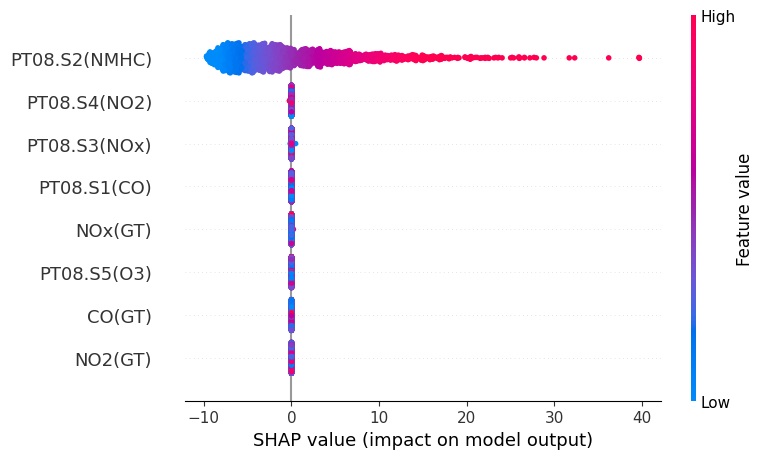

In [ ]:
# Access feature importance from the tuned model
feature_importance = best_dt_regressor.feature_importances_

# Map feature names to their importance scores
features = X.columns
feature_importance_dict = dict(zip(features, feature_importance))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features:')
for feature, importance in sorted_features[:5]:
    print(f'{feature}: {importance}')

# Additionally, you can use tools like SHAP values or tree interpreters to gain insights into model predictions.
# Example with SHAP values:
import shap
explainer = shap.TreeExplainer(best_dt_regressor)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


PT08.S2(NMHC):

This feature has an extremely high importance score, close to 1.0. It indicates that PT08.S2(NMHC) is the most influential feature in making predictions with this model. Changes in this feature have a substantial impact on the model's output.

PT08.S4(NO2):

While this feature has a much lower importance score compared to PT08.S2(NMHC), it still contributes to the model's predictions. The low score suggests that PT08.S4(NO2) has a minor impact on the model compared to PT08.S2(NMHC).

PT08.S3(NOx):

Similar to PT08.S4(NO2), PT08.S3(NOx) has a relatively low importance score. It contributes less to the model's predictions, indicating that changes in this feature have a smaller effect on the model compared to PT08.S2(NMHC).

NO2(GT):

NO2(GT) also has a low importance score, suggesting a minor impact on the model's predictions. It is less influential compared to PT08.S2(NMHC).

PT08.S5(O3):

PT08.S5(O3) has a very low importance score, indicating a minimal contribution to the model's predictions. Changes in this feature have the least impact among the top features.

# Random Forest Regressor

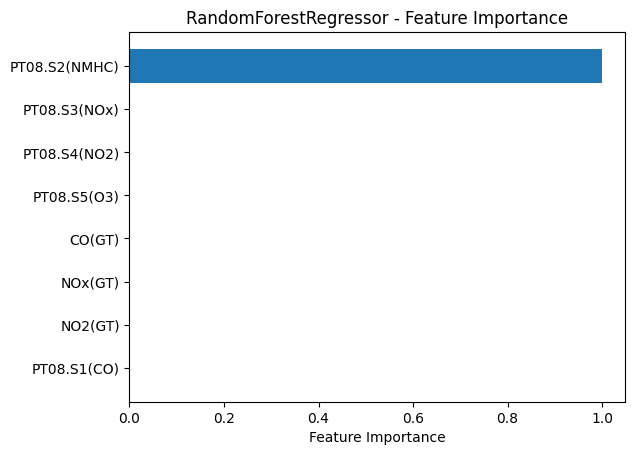


===== Model Evaluation =====
Mean Squared Error: 0.0083
R-squared: 0.9999
Mean Absolute Error: 0.0150
Explained Variance: 0.9999
Root Mean Squared Error: 0.0912
{'Mean Squared Error': 0.008317229571984277, 'R-squared': 0.9998552573044744, 'Mean Absolute Error': 0.014951639799893411, 'Explained Variance': 0.9998553231750911, 'Root Mean Squared Error': 0.0911988463303362}


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Fit the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

evaluation_results = evaluate_model(rf_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)


A low MSE (0.0083 in this case) indicates that the model's predictions are close to the actual values. It suggests good accuracy in predicting numerical outcomes.

An R-squared value close to 1 (0.9999 here) indicates that the model explains almost all of the variance in the target variable. This suggests an excellent fit of the model to the data.

A low MAE (0.0150 in this case) suggests that, on average, the model's predictions deviate minimally from the actual values.

A value of 0.9999 indicates that the model can explain 99.99% of the variance in the target variable, indicating very high explanatory power.

An RMSE of 0.0912 suggests that, on average, the model's predictions deviate by approximately 0.0912 units from the actual values.

In summary, the Random Forest Regressor has produced highly promising results based on these evaluation metrics. The model seems to fit the data very well, providing accurate predictions with minimal errors.

Best Hyperparameters (Random Forest): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}


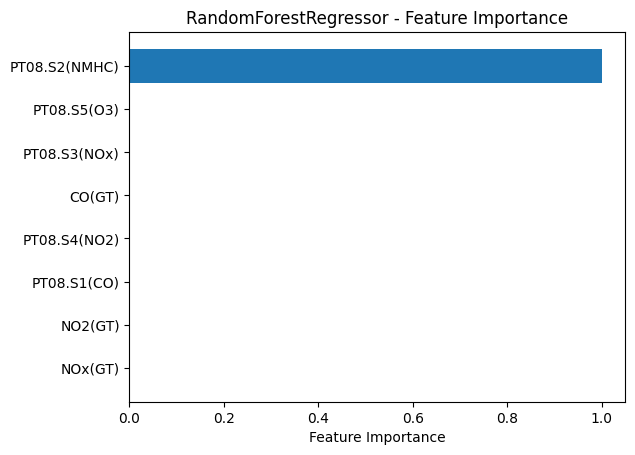


===== Model Evaluation =====
Mean Squared Error: 0.0016
R-squared: 1.0000
Mean Absolute Error: 0.0123
Explained Variance: 1.0000
Root Mean Squared Error: 0.0401
{'Mean Squared Error': 0.0016091839904006683, 'R-squared': 0.9999719957677793, 'Mean Absolute Error': 0.012293573243309855, 'Explained Variance': 0.9999720438338826, 'Root Mean Squared Error': 0.04011463561345994}


In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid_rf = {
    'n_estimators': [150],
    'max_depth': [30,40],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [ 4]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error')

# Fit the model with GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Hyperparameters (Random Forest): {best_params_rf}')

# Use the best model
best_rf_regressor = grid_search_rf.best_estimator_

# Make predictions
y_pred_tuned_rf = best_rf_regressor.predict(X_test)

# Evaluate the tuned model
evaluation_results = evaluate_model(best_rf_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)


The MSE of 0.0016 is significantly lower than the untuned model (0.0083). This indicates that the tuned model's predictions are even closer to the actual values, suggesting improved accuracy.

The R-squared value of 1.0000 is a perfect score, indicating that the tuned model explains all the variability in the data. While this might be a sign of overfitting, it could also suggest that the model is an excellent fit for the specific dataset.

The MAE of 0.0123 is lower than the untuned model (0.0150), showing that, on average, the tuned model's predictions deviate even less from the actual values.

The Explained Variance of 1.0000 means that the tuned model can perfectly explain the variance in the target variable. This could be a result of overfitting, and caution should be taken to ensure the model generalizes well to unseen data.

The RMSE of 0.0401 is lower than the untuned model (0.0912), indicating that the tuned model's predictions have a smaller average deviation from the actual values.

In summary, the tuned Random Forest Regressor seems to perform exceptionally well on the evaluation metrics.

In [ ]:
# Access feature importance from the tuned Random Forest model
feature_importance_rf = best_rf_regressor.feature_importances_

# Map feature names to their importance scores
features_rf = X.columns
feature_importance_dict_rf = dict(zip(features_rf, feature_importance_rf))

# Sort features by importance
sorted_features_rf = sorted(feature_importance_dict_rf.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features (Random Forest):')
for feature, importance in sorted_features_rf[:5]:
    print(f'{feature}: {importance}')


Most Influential Features (Random Forest):
PT08.S2(NMHC): 0.9999559506566218
PT08.S5(O3): 2.893834277631444e-05
PT08.S3(NOx): 9.028580493643792e-06
CO(GT): 3.2123884244209566e-06
PT08.S4(NO2): 1.1928004318855863e-06


The Random Forest model considers PT08.S2(NMHC) as the most influential feature, with PT08.S5(O3) and PT08.S3(NOx) following with lower importance. CO(GT) and PT08.S4(NO2) seem to have the least impact on the model's predictions.

# XGBoost

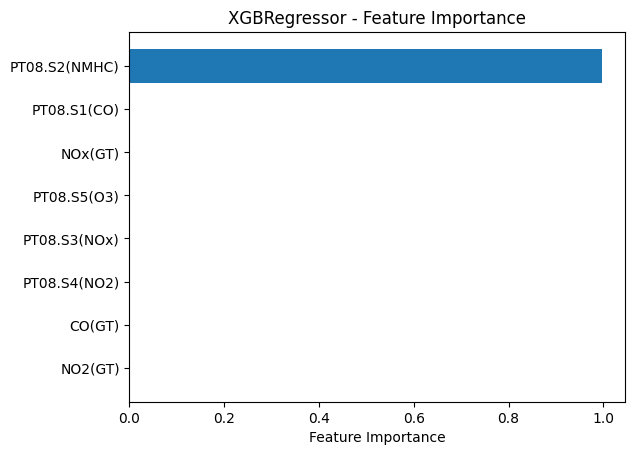


===== Model Evaluation =====
Mean Squared Error: 0.0590
R-squared: 0.9990
Mean Absolute Error: 0.0656
Explained Variance: 0.9990
Root Mean Squared Error: 0.2428
{'Mean Squared Error': 0.05895806958399995, 'R-squared': 0.9989739672518696, 'Mean Absolute Error': 0.06561045862357442, 'Explained Variance': 0.9989739773117751, 'Root Mean Squared Error': 0.24281282829372905}


In [ ]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(random_state=42)

# Fit the model
xgb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_regressor.predict(X_test)


# Evaluate the model
evaluation_results = evaluate_model(xgb_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)


The XGBoost model demonstrates outstanding performance on all evaluated metrics, with R-squared and explained variance near 1, indicating a near-perfect fit to the data.
The low values for MSE, MAE, and RMSE suggest that the model's predictions closely align with the actual values.

Best Hyperparameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


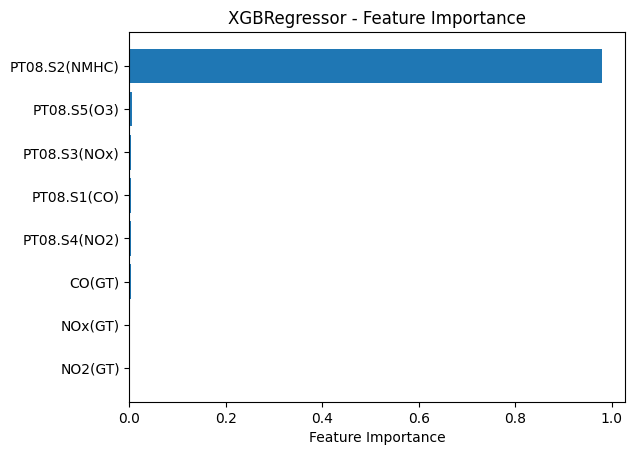


===== Model Evaluation =====
Mean Squared Error: 0.0403
R-squared: 0.9993
Mean Absolute Error: 0.0788
Explained Variance: 0.9993
Root Mean Squared Error: 0.2006
{'Mean Squared Error': 0.04025609401106823, 'R-squared': 0.9992994331215623, 'Mean Absolute Error': 0.0787859104851208, 'Explained Variance': 0.9992997932775005, 'Root Mean Squared Error': 0.20063921354278735}


In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error')

# Fit the model with GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print(f'Best Hyperparameters (XGBoost): {best_params_xgb}')

# Use the best model
best_xgb_regressor = grid_search_xgb.best_estimator_

# Make predictions
y_pred_tuned_xgb = best_xgb_regressor.predict(X_test)

evaluation_results = evaluate_model(best_xgb_regressor, X_train, X_test, y_train, y_test, feature_names=X.columns)
print(evaluation_results)


The XGBoost tuned model maintains an outstanding level of performance, with all key metrics approaching perfection.
The tuned version shows slight improvements in MSE, suggesting even closer alignment of predicted and actual values.

In [ ]:
# Access feature importance from the tuned XGBoost model
feature_importance_xgb = best_xgb_regressor.feature_importances_

# Map feature names to their importance scores
features_xgb = X.columns
feature_importance_dict_xgb = dict(zip(features_xgb, feature_importance_xgb))

# Sort features by importance
sorted_features_xgb = sorted(feature_importance_dict_xgb.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features (XGBoost):')
for feature, importance in sorted_features_xgb[:5]:
    print(f'{feature}: {importance}')


Most Influential Features (XGBoost):
PT08.S2(NMHC): 0.9796422719955444
PT08.S5(O3): 0.0045524402521550655
PT08.S3(NOx): 0.003999718930572271
PT08.S1(CO): 0.003983150701969862
PT08.S4(NO2): 0.0027600321918725967


PT08.S2(NMHC) is identified as an overwhelmingly dominant feature, signifying its critical role in the model's predictions.
The other features contribute to a lesser extent, with PT08.S5(O3), PT08.S3(NOx), PT08.S1(CO), and PT08.S4(NO2) having progressively lower importance scores.

# Decision Tree Classifier

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
     recall_score, roc_curve, roc_auc_score, f1_score, classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    print('\n')
    # Accuracy, Precision, Recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
    print('\n')
    # ROC Curve and AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC-AUC: {auc:.2f}')
    print('\n')
    # F1 and F-beta Score
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1:.2f}')
    print('\n')
    # Full classification report
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
[[18784  3113]
 [ 2947  3314]]



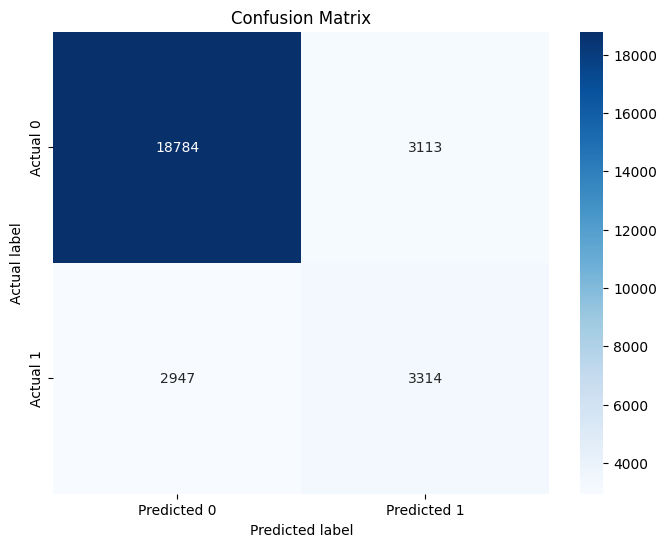



Accuracy: 0.78, Precision: 0.52, Recall: 0.53


ROC-AUC: 0.69


F1 Score: 0.52



Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     21897
           1       0.52      0.53      0.52      6261

    accuracy                           0.78     28158
   macro avg       0.69      0.69      0.69     28158
weighted avg       0.79      0.78      0.79     28158



In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_clean.drop('RainTomorrow', axis=1)
y = df_clean['RainTomorrow']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Evaluate the model

evaluate_model(dt_classifier, X_test, y_test)

The model performs reasonably well with an accuracy of 78%. However, the precision and recall for class 1 (positive class) are relatively lower, suggesting that there may be room for improvement, especially in correctly identifying positive instances. The ROC-AUC value of 0.69 indicates a moderate performance in distinguishing between the two classes

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Confusion Matrix:
[[20992   905]
 [ 3676  2585]]



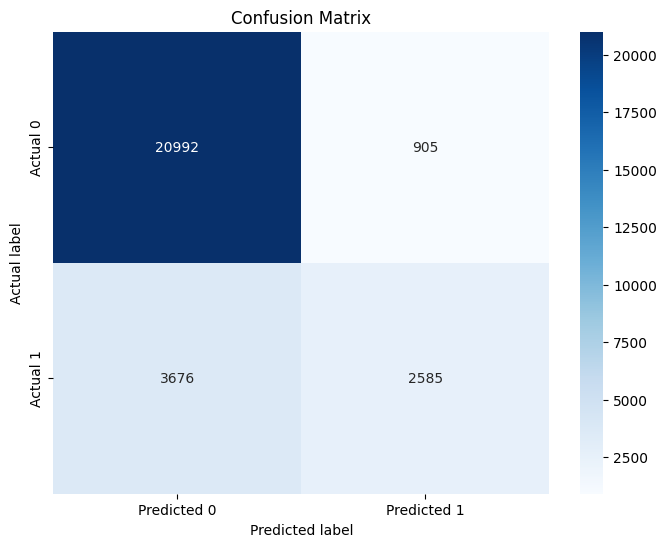



Accuracy: 0.84, Precision: 0.74, Recall: 0.41


ROC-AUC: 0.83


F1 Score: 0.53



Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90     21897
           1       0.74      0.41      0.53      6261

    accuracy                           0.84     28158
   macro avg       0.80      0.69      0.72     28158
weighted avg       0.83      0.84      0.82     28158



In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best model
best_dt_classifier = grid_search.best_estimator_

# Make predictions
y_pred_tuned = best_dt_classifier.predict(X_test)

# Evaluate the tuned model
evaluate_model(best_dt_classifier, X_test, y_test)

The tuned Decision Tree Classifier performs well with an accuracy of 84%, indicating an improvement over the untuned version. The precision for the positive class has increased to 0.74, while the recall has decreased to 0.41. The ROC-AUC value of 0.83 suggests good discriminatory power.

In [ ]:
# Access feature importance from the tuned model
feature_importance = best_dt_classifier.feature_importances_

# Map feature names to their importance scores
features = X.columns
feature_importance_dict = dict(zip(features, feature_importance))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features:')
for feature, importance in sorted_features[:5]:
    print(f'{feature}: {importance}')


Most Influential Features:
Humidity3pm: 0.7472261106448617
WindGustSpeed: 0.09613169383688999
Pressure3pm: 0.056159946120272766
Rainfall: 0.0469321869841791
Sunshine: 0.03877563618460839




Humidity3pm is the most influential feature, with a high importance score of 0.7472. This suggests that the model places significant emphasis on the humidity level at 3 pm when making predictions. High humidity at this time appears to strongly influence the outcome.


WindGustSpeed is the second most influential feature, with an importance score of 0.0961. While not as dominant as humidity, wind gust speed still plays a notable role in the model's decision-making process. Higher wind gust speeds likely contribute to the

Pressure3pm is the third most influential feature, with an importance score of 0.0562. Atmospheric pressure at 3 pm is considered by the model as a relevant factor. Changes in pressure may have a correlation with the target variable.


Rainfall is the fourth most influential feature, with an importance score of 0.0469. The amount of rainfall is still considered important, though to a lesser extent compared to humidity and wind gust speed.


Sunshine is the fifth most influential feature, with an importance score of 0.0388. The duration of sunshine appears to have a moderate impact on the model's predictions. More sunshine may be associated with specific outcomes.

#  Random Forest Classifier

Confusion Matrix:
[[20970   927]
 [ 3096  3165]]



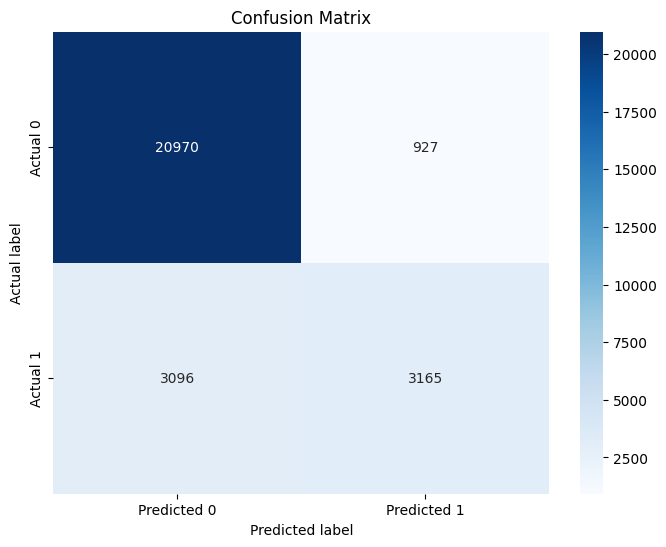



Accuracy: 0.86, Precision: 0.77, Recall: 0.51


ROC-AUC: 0.89


F1 Score: 0.61



Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     21897
           1       0.77      0.51      0.61      6261

    accuracy                           0.86     28158
   macro avg       0.82      0.73      0.76     28158
weighted avg       0.85      0.86      0.85     28158



In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

evaluate_model(rf_classifier, X_test, y_test)


The model shows a good overall accuracy (86%) and precision (77%), but there is room for improvement in recall (51%) for the positive class.
The ROC-AUC of 0.89 indicates strong discrimination between classes.
The F1 score of 0.61 suggests a balance between precision and recall, considering false positives and false negatives.

Best Hyperparameters (Random Forest): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Confusion Matrix:
[[20971   926]
 [ 3165  3096]]



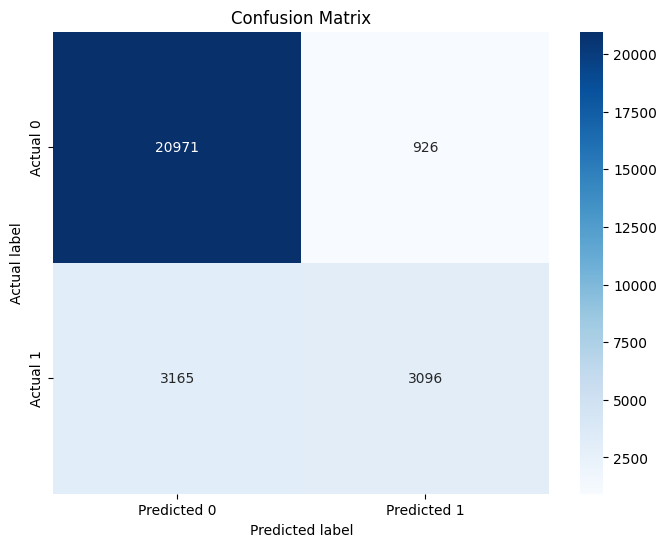



Accuracy: 0.85, Precision: 0.77, Recall: 0.49


ROC-AUC: 0.89


F1 Score: 0.60



Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     21897
           1       0.77      0.49      0.60      6261

    accuracy                           0.85     28158
   macro avg       0.82      0.73      0.76     28158
weighted avg       0.85      0.85      0.84     28158



In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid_rf = {
    'n_estimators': [150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [4]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=3, scoring='accuracy')

# Fit the model with GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Hyperparameters (Random Forest): {best_params_rf}')

# Use the best model
best_rf_classifier = grid_search_rf.best_estimator_

# Make predictions
y_pred_tuned_rf = best_rf_classifier.predict(X_test)

# Evaluate the tuned model
evaluate_model(best_rf_classifier, X_test, y_test)


The tuning process did not result in significant improvements in the model's performance metrics for this particular dataset.
The RandomForestClassifier, whether tuned or untuned, shows a consistent and balanced performance with good accuracy, precision, and recall.

In [ ]:
# Access feature importance from the tuned Random Forest model
feature_importance_rf = best_rf_classifier.feature_importances_

# Map feature names to their importance scores
features_rf = X.columns
feature_importance_dict_rf = dict(zip(features_rf, feature_importance_rf))

# Sort features by importance
sorted_features_rf = sorted(feature_importance_dict_rf.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features (Random Forest):')
for feature, importance in sorted_features_rf[:5]:
    print(f'{feature}: {importance}')


Most Influential Features (Random Forest):
Humidity3pm: 0.21905338511555178
Sunshine: 0.0626430539284406
Pressure3pm: 0.05816598585679323
Rainfall: 0.05694972432617768
WindGustSpeed: 0.05598400512843176


The Random Forest model identifies Humidity3pm as the most influential feature, reinforcing the importance of humidity in predicting the target variable.
Sunshine, Rainfall, Pressure3pm, and WindGustSpeed also contribute to the model's understanding of the target variable, with varying degrees of importance

# Boosting Classifier

Confusion Matrix:
[[20770  1127]
 [ 2783  3478]]



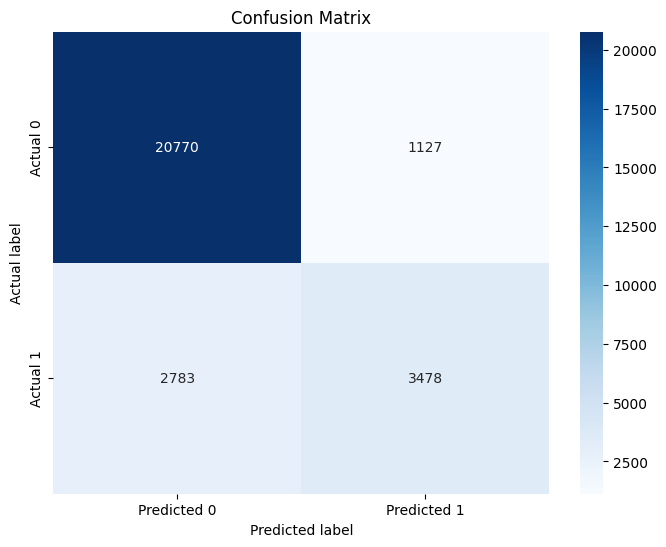



Accuracy: 0.86, Precision: 0.76, Recall: 0.56


ROC-AUC: 0.90


F1 Score: 0.64



Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     21897
           1       0.76      0.56      0.64      6261

    accuracy                           0.86     28158
   macro avg       0.82      0.75      0.78     28158
weighted avg       0.85      0.86      0.85     28158



In [ ]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
evaluate_model(xgb_classifier, X_test, y_test)


The Boosting Classifier shows a good overall accuracy (86%) and precision (76%), with an improvement in recall (56%) compared to the Random Forest Classifier.
The ROC-AUC of 0.90 indicates strong discrimination between classes.
The F1 score of 0.64 suggests a balance between precision and recall, considering false positives and false negatives.

Best Hyperparameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Confusion Matrix:
[[20813  1084]
 [ 2716  3545]]



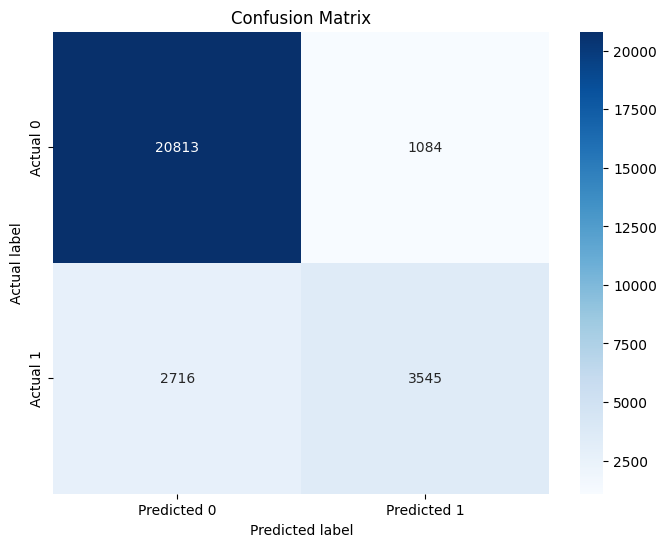



Accuracy: 0.87, Precision: 0.77, Recall: 0.57


ROC-AUC: 0.90


F1 Score: 0.65



Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     21897
           1       0.77      0.57      0.65      6261

    accuracy                           0.87     28158
   macro avg       0.83      0.76      0.78     28158
weighted avg       0.86      0.87      0.86     28158



In [ ]:
# Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid_xgb, cv=3, scoring='accuracy')

# Fit the model with GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print(f'Best Hyperparameters (XGBoost): {best_params_xgb}')

# Use the best model
best_xgb_classifier = grid_search_xgb.best_estimator_

# Make predictions
y_pred_tuned_xgb = best_xgb_classifier.predict(X_test)

# Evaluate the tuned model
evaluate_model(best_xgb_classifier, X_test, y_test)


The tuned Boosting Classifier shows a good overall accuracy (87%) and precision (77%), with an improvement in recall (57%) compared to the untuned model.
The ROC-AUC of 0.90 indicates strong discrimination between classes.
The F1 score of 0.65 suggests a balance between precision and recall, considering false positives and false negatives.

In [ ]:
# Access feature importance from the tuned XGBoost model
feature_importance_xgb = best_xgb_classifier.feature_importances_

# Map feature names to their importance scores
features_xgb = X.columns
feature_importance_dict_xgb = dict(zip(features_xgb, feature_importance_xgb))

# Sort features by importance
sorted_features_xgb = sorted(feature_importance_dict_xgb.items(), key=lambda x: x[1], reverse=True)

# Print the most influential features
print('Most Influential Features (XGBoost):')
for feature, importance in sorted_features_xgb[:5]:
    print(f'{feature}: {importance}')


Most Influential Features (XGBoost):
Humidity3pm: 0.3031984269618988
WindGustSpeed: 0.07085750997066498
Pressure3pm: 0.05698472633957863
Sunshine: 0.056626010686159134
Rainfall: 0.054660432040691376


The Boosting Classifier (XGBoost) identifies Humidity3pm as the most influential feature in making predictions. WindGustSpeed, Pressure3pm, Sunshine, and Rainfall follow in descending order of importance. These features collectively contribute to the model's understanding of the target variable.

# weight

Confusion Matrix:
[[21066   831]
 [ 3297  2964]]



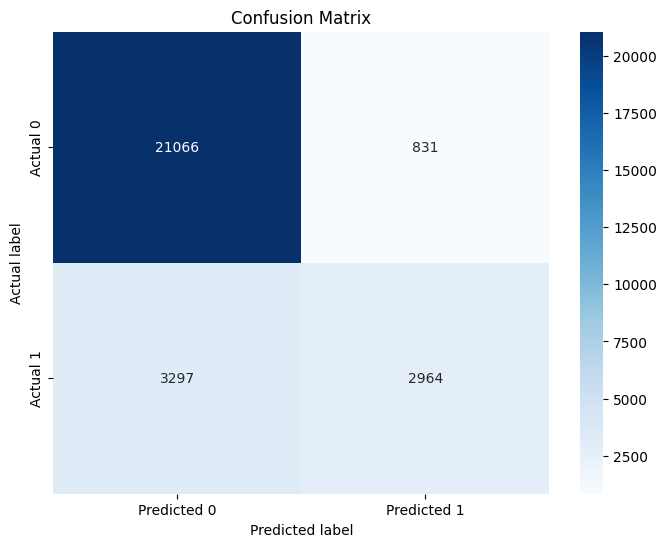



Accuracy: 0.85, Precision: 0.78, Recall: 0.47


ROC-AUC: 0.89


F1 Score: 0.59



Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91     21897
           1       0.78      0.47      0.59      6261

    accuracy                           0.85     28158
   macro avg       0.82      0.72      0.75     28158
weighted avg       0.85      0.85      0.84     28158



In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Initialize the RandomForestClassifier with class weights
rf_classifier_weighted = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=42)

# Fit the model
rf_classifier_weighted.fit(X_train, y_train)

# Make predictions
y_pred_weighted = rf_classifier_weighted.predict(X_test)

# Evaluate the model with class weights
evaluate_model(rf_classifier_weighted, X_test, y_test)

The weighted RandomForestClassifier shows a good overall accuracy (85%) and precision (78%), but with a lower recall (47%) for the positive class.
The ROC-AUC of 0.89 indicates good discrimination between classes.
The F1 score of 0.59 suggests a balance between precision and recall, considering false positives and false negatives.